In [1]:
import torch
import torch.nn as nn
import torch.optim as optim

import torchtext
from torch.utils.data import Dataset
from torchtext.legacy import data
from torchtext.legacy.data import Field, BucketIterator

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import numpy as np

import random
from random import randint
import math
import time

import zipfile
import os
import re
import csv
import unicodedata
import codecs
from io import open
import itertools
from collections import Counter
import json
import pandas as pd
from pathlib import Path

In [2]:
SEED = 1123

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [3]:
my_file = Path("./english_python_data.txt")
if my_file.is_file():
  file1 = open(my_file, 'r')
  Lines = file1.readlines()
else:
  print ("file does not exist. Please upload the file")

In [4]:
df = pd.DataFrame(columns = ['SRC', 'TRG'])

src = ""
tgt = ""
count = 0
last_line = "test"
for line in Lines:
  if last_line.strip() == "" and line.strip() != "":
    if line[0] == '#' and tgt.strip() != "":
      if ((len(src)> 450) or (len(tgt) > 450)):
        print("Ignoring the source and target")
        print(src, tgt)
      else:
        df.loc[len(df.index)] = [src.strip(), tgt.strip()]
        count = count + 1
      
      src = ""
      tgt = ""

  if line.strip() != "":
    if line.strip()[0] == '#':
      src = src + line.replace("#", "")
    else:
      tgt = tgt + line
  
  last_line = line




Streaming output truncated to the last 5000 lines.
print("3.Multiply")  
print("4.Divide")  
choice = input("Enter choice(1/2/3/4):")  
num1 = int(input("Enter first number: "))  
num2 = int(input("Enter second number: "))  
if choice == '1':  
   print(num1,"+",num2,"=", add(num1,num2))  
elif choice == '2':  
   print(num1,"-",num2,"=", subtract(num1,num2))  
elif choice == '3':  
   print(num1,"*",num2,"=", multiply(num1,num2))  
elif choice == '4':  
   print(num1,"/",num2,"=", divide(num1,num2))  
else:  
   print("Invalid input")    

Ignoring the source and target
62 write a program to sort the elements of the array
 arr = [5, 2, 8, 7, 1];     
temp = 0;    
print("Elements of original array: ");    
for i in range(0, len(arr)):    
    print(arr[i], end=" ");    
for i in range(0, len(arr)):    
    for j in range(i+1, len(arr)):    
        if(arr[i] > arr[j]):    
            temp = arr[i];    
            arr[i] = arr[j];    
            arr[j] = temp;    
print();    
print

In [5]:
df = df.dropna()

In [6]:
def rev_sentence(sentence):  
  
    # first split the string into words  
    words = sentence.split(' ')  
  
    # then reverse the split string list and join using space  
    reverse_sentence = ' '.join(reversed(words))  
  
    # finally return the joined string  
    return reverse_sentence  

In [7]:
print(len(df))
x = [randint(0, len(df)) for p in range(0, len(df)//2)]
x = set(x)
for i in x:
  new_src = rev_sentence(df["SRC"][i])
  new_trg = df["TRG"][i]
  df.loc[len(df.index)] = [new_src, new_trg]


print(len(df))

4403
6133


In [8]:
print(df)
df.to_csv("Data.csv")

                                                    SRC                                                TRG
0             write a python program to add two numbers  num1 = 1.5\nnum2 = 6.3\nsum = num1 + num2\npri...
1     write a python function to add two user provid...  def add_two_numbers(num1, num2):\n    sum = nu...
2     write a program to find and print the largest ...  num1 = 10\nnum2 = 12\nnum3 = 14\nif (num1 >= n...
3     write a program to find and print the smallest...  num1 = 10\nnum2 = 12\nnum3 = 14\nif (num1 <= n...
4     Write a python function to merge two given lis...       def merge_lists(l1, l2):\n    return l1 + l2
...                                                 ...                                                ...
6128         number a of cosine find to program a write  import math\nnum = 45\nprint("Cosine", math.co...
6129            number a of sin find to program a write  import math\nnum = 45\nprint("Sin", math.sin(n...
6130        number a of tangent find 

In [9]:
SRC = Field(tokenize = 'spacy', 
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True, 
            batch_first = True)

TRG = Field(tokenize = 'spacy', 
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True, 
            batch_first = True)

In [10]:
fields = [('SRC', SRC),('TRG',TRG)]

example = [data.Example.fromlist([df.SRC[i],df.TRG[i]], fields) for i in range(df.shape[0])] 
bot_qa = data.Dataset(example, fields)

(train_data, valid_data, test_data) = bot_qa.split(split_ratio=[0.80, 0.10, 0.10], random_state=random.seed(SEED))

In [11]:
SRC.build_vocab(train_data, min_freq = 1)
TRG.build_vocab(train_data, min_freq = 1)

print(f"Unique tokens in SRC vocabulary: {len(SRC.vocab)}")
print(f"Unique tokens in TRG vocabulary: {len(TRG.vocab)}")

Unique tokens in SRC vocabulary: 2206
Unique tokens in TRG vocabulary: 8415


In [12]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [13]:
BATCH_SIZE = 64

train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data), 
     sort= False,
     batch_size = BATCH_SIZE,
     device = device)

In [14]:
class Encoder(nn.Module):
    def __init__(self, 
                 input_dim, 
                 hid_dim, 
                 n_layers, 
                 n_heads, 
                 pf_dim,
                 dropout, 
                 device,
                 max_length = 500):
        super().__init__()

        self.device = device
        
        self.tok_embedding = nn.Embedding(input_dim, hid_dim)
        self.pos_embedding = nn.Embedding(max_length, hid_dim)
        
        self.layers = nn.ModuleList([EncoderLayer(hid_dim, 
                                                  n_heads, 
                                                  pf_dim,
                                                  dropout, 
                                                  device) 
                                     for _ in range(n_layers)])
        
        self.dropout = nn.Dropout(dropout)
        
        self.scale = torch.sqrt(torch.FloatTensor([hid_dim])).to(device)
        
    def forward(self, src, src_mask):
        
        #src = [batch size, src len]
        #src_mask = [batch size, 1, 1, src len]
        
        batch_size = src.shape[0]
        src_len = src.shape[1]
        
        pos = torch.arange(0, src_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)
        
        #pos = [batch size, src len]
        
        src = self.dropout((self.tok_embedding(src) * self.scale) + self.pos_embedding(pos))
        
        #src = [batch size, src len, hid dim]
        
        for layer in self.layers:
            src = layer(src, src_mask)
            
        #src = [batch size, src len, hid dim]
            
        return src

In [15]:
class EncoderLayer(nn.Module):
    def __init__(self, 
                 hid_dim, 
                 n_heads, 
                 pf_dim,  
                 dropout, 
                 device):
        super().__init__()
        
        self.self_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.ff_layer_norm = nn.LayerNorm(hid_dim)
        self.self_attention = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device)
        self.positionwise_feedforward = PositionwiseFeedforwardLayer(hid_dim, 
                                                                     pf_dim, 
                                                                     dropout)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, src, src_mask):
        
        #src = [batch size, src len, hid dim]
        #src_mask = [batch size, 1, 1, src len] 
                
        #self attention
        _src, _ = self.self_attention(src, src, src, src_mask)
        
        #dropout, residual connection and layer norm
        src = self.self_attn_layer_norm(src + self.dropout(_src))
        
        #src = [batch size, src len, hid dim]
        
        #positionwise feedforward
        _src = self.positionwise_feedforward(src)
        
        #dropout, residual and layer norm
        src = self.ff_layer_norm(src + self.dropout(_src))
        
        #src = [batch size, src len, hid dim]
        
        return src

In [16]:
class MultiHeadAttentionLayer(nn.Module):
    def __init__(self, hid_dim, n_heads, dropout, device):
        super().__init__()
        
        assert hid_dim % n_heads == 0
        
        self.hid_dim = hid_dim
        self.n_heads = n_heads
        self.head_dim = hid_dim // n_heads
        
        self.fc_q = nn.Linear(hid_dim, hid_dim)
        self.fc_k = nn.Linear(hid_dim, hid_dim)
        self.fc_v = nn.Linear(hid_dim, hid_dim)
        
        self.fc_o = nn.Linear(hid_dim, hid_dim)
        
        self.dropout = nn.Dropout(dropout)
        
        self.scale = torch.sqrt(torch.FloatTensor([self.head_dim])).to(device)
        
    def forward(self, query, key, value, mask = None):
        
        batch_size = query.shape[0]
        
        #query = [batch size, query len, hid dim]
        #key = [batch size, key len, hid dim]
        #value = [batch size, value len, hid dim]
                
        Q = self.fc_q(query)
        K = self.fc_k(key)
        V = self.fc_v(value)
        
        #Q = [batch size, query len, hid dim]
        #K = [batch size, key len, hid dim]
        #V = [batch size, value len, hid dim]
                
        Q = Q.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        K = K.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        V = V.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        
        #Q = [batch size, n heads, query len, head dim]
        #K = [batch size, n heads, key len, head dim]
        #V = [batch size, n heads, value len, head dim]
                
        energy = torch.matmul(Q, K.permute(0, 1, 3, 2)) / self.scale
        
        #energy = [batch size, n heads, query len, key len]
        
        if mask is not None:
            energy = energy.masked_fill(mask == 0, -1e10)
        
        attention = torch.softmax(energy, dim = -1)
                
        #attention = [batch size, n heads, query len, key len]
                
        x = torch.matmul(self.dropout(attention), V)
        
        #x = [batch size, n heads, query len, head dim]
        
        x = x.permute(0, 2, 1, 3).contiguous()
        
        #x = [batch size, query len, n heads, head dim]
        
        x = x.view(batch_size, -1, self.hid_dim)
        
        #x = [batch size, query len, hid dim]
        
        x = self.fc_o(x)
        
        #x = [batch size, query len, hid dim]
        
        return x, attention

In [17]:
class PositionwiseFeedforwardLayer(nn.Module):
    def __init__(self, hid_dim, pf_dim, dropout):
        super().__init__()
        
        self.fc_1 = nn.Linear(hid_dim, pf_dim)
        self.fc_2 = nn.Linear(pf_dim, hid_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        
        #x = [batch size, seq len, hid dim]
        
        x = self.dropout(torch.relu(self.fc_1(x)))
        
        #x = [batch size, seq len, pf dim]
        
        x = self.fc_2(x)
        
        #x = [batch size, seq len, hid dim]
        
        return x

In [18]:
class Decoder(nn.Module):
    def __init__(self, 
                 output_dim, 
                 hid_dim, 
                 n_layers, 
                 n_heads, 
                 pf_dim, 
                 dropout, 
                 device,
                 max_length = 500):
        super().__init__()
        
        self.device = device
        
        self.tok_embedding = nn.Embedding(output_dim, hid_dim)
        self.pos_embedding = nn.Embedding(max_length, hid_dim)
        
        self.layers = nn.ModuleList([DecoderLayer(hid_dim, 
                                                  n_heads, 
                                                  pf_dim, 
                                                  dropout, 
                                                  device)
                                     for _ in range(n_layers)])
        
        self.fc_out = nn.Linear(hid_dim, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
        self.scale = torch.sqrt(torch.FloatTensor([hid_dim])).to(device)
        
    def forward(self, trg, enc_src, trg_mask, src_mask):
        
        #trg = [batch size, trg len]
        #enc_src = [batch size, src len, hid dim]
        #trg_mask = [batch size, 1, trg len, trg len]
        #src_mask = [batch size, 1, 1, src len]
                
        batch_size = trg.shape[0]
        trg_len = trg.shape[1]
        
        pos = torch.arange(0, trg_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)
                            
        #pos = [batch size, trg len]
            
        trg = self.dropout((self.tok_embedding(trg) * self.scale) + self.pos_embedding(pos))
                
        #trg = [batch size, trg len, hid dim]
        
        for layer in self.layers:
            trg, attention = layer(trg, enc_src, trg_mask, src_mask)
        
        #trg = [batch size, trg len, hid dim]
        #attention = [batch size, n heads, trg len, src len]
        
        output = self.fc_out(trg)
        
        #output = [batch size, trg len, output dim]
            
        return output, attention

In [19]:
class DecoderLayer(nn.Module):
    def __init__(self, 
                 hid_dim, 
                 n_heads, 
                 pf_dim, 
                 dropout, 
                 device):
        super().__init__()
        
        self.self_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.enc_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.ff_layer_norm = nn.LayerNorm(hid_dim)
        self.self_attention = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device)
        self.encoder_attention = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device)
        self.positionwise_feedforward = PositionwiseFeedforwardLayer(hid_dim, 
                                                                     pf_dim, 
                                                                     dropout)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, trg, enc_src, trg_mask, src_mask):
        
        #trg = [batch size, trg len, hid dim]
        #enc_src = [batch size, src len, hid dim]
        #trg_mask = [batch size, 1, trg len, trg len]
        #src_mask = [batch size, 1, 1, src len]
        
        #self attention
        _trg, _ = self.self_attention(trg, trg, trg, trg_mask)
        
        #dropout, residual connection and layer norm
        trg = self.self_attn_layer_norm(trg + self.dropout(_trg))
            
        #trg = [batch size, trg len, hid dim]
            
        #encoder attention
        _trg, attention = self.encoder_attention(trg, enc_src, enc_src, src_mask)
        # query, key, value
        
        #dropout, residual connection and layer norm
        trg = self.enc_attn_layer_norm(trg + self.dropout(_trg))
                    
        #trg = [batch size, trg len, hid dim]
        
        #positionwise feedforward
        _trg = self.positionwise_feedforward(trg)
        
        #dropout, residual and layer norm
        trg = self.ff_layer_norm(trg + self.dropout(_trg))
        
        #trg = [batch size, trg len, hid dim]
        #attention = [batch size, n heads, trg len, src len]
        
        return trg, attention

In [20]:
class Seq2Seq(nn.Module):
    def __init__(self, 
                 encoder, 
                 decoder, 
                 src_pad_idx, 
                 trg_pad_idx, 
                 device):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        self.src_pad_idx = src_pad_idx
        self.trg_pad_idx = trg_pad_idx
        self.device = device
        
    def make_src_mask(self, src):
        
        #src = [batch size, src len]
        
        src_mask = (src != self.src_pad_idx).unsqueeze(1).unsqueeze(2)

        #src_mask = [batch size, 1, 1, src len]

        return src_mask
    
    def make_trg_mask(self, trg):
        
        #trg = [batch size, trg len]
        
        trg_pad_mask = (trg != self.trg_pad_idx).unsqueeze(1).unsqueeze(2)
        
        #trg_pad_mask = [batch size, 1, 1, trg len]
        
        trg_len = trg.shape[1]
        
        trg_sub_mask = torch.tril(torch.ones((trg_len, trg_len), device = self.device)).bool()
        
        #trg_sub_mask = [trg len, trg len]
            
        trg_mask = trg_pad_mask & trg_sub_mask
        
        #trg_mask = [batch size, 1, trg len, trg len]
        
        return trg_mask

    def forward(self, src, trg):
        
        #src = [batch size, src len]
        #trg = [batch size, trg len]
                
        src_mask = self.make_src_mask(src)
        trg_mask = self.make_trg_mask(trg)
        
        #src_mask = [batch size, 1, 1, src len]
        #trg_mask = [batch size, 1, trg len, trg len]
        
        enc_src = self.encoder(src, src_mask)
        
        #enc_src = [batch size, src len, hid dim]
                
        output, attention = self.decoder(trg, enc_src, trg_mask, src_mask)
        
        #output = [batch size, trg len, output dim]
        #attention = [batch size, n heads, trg len, src len]
        
        return output, attention

In [21]:
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
HID_DIM = 256
ENC_LAYERS = 3
DEC_LAYERS = 3
ENC_HEADS = 8
DEC_HEADS = 8
ENC_PF_DIM = 512
DEC_PF_DIM = 512
ENC_DROPOUT = 0.1
DEC_DROPOUT = 0.1

enc = Encoder(INPUT_DIM, 
              HID_DIM, 
              ENC_LAYERS, 
              ENC_HEADS, 
              ENC_PF_DIM, 
              ENC_DROPOUT, 
              device)

dec = Decoder(OUTPUT_DIM, 
              HID_DIM, 
              DEC_LAYERS, 
              DEC_HEADS, 
              DEC_PF_DIM, 
              DEC_DROPOUT, 
              device)

In [22]:
SRC_PAD_IDX = SRC.vocab.stoi[SRC.pad_token]
TRG_PAD_IDX = TRG.vocab.stoi[TRG.pad_token]

model = Seq2Seq(enc, dec, SRC_PAD_IDX, TRG_PAD_IDX, device).to(device)

In [23]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 9,091,295 trainable parameters


In [24]:
def initialize_weights(m):
    if hasattr(m, 'weight') and m.weight.dim() > 1:
        nn.init.xavier_uniform_(m.weight.data)

In [25]:
model.apply(initialize_weights);

In [26]:
LEARNING_RATE = 0.0005

optimizer = torch.optim.Adam(model.parameters(), lr = LEARNING_RATE, weight_decay=1e-5)

In [27]:
criterion = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX)

In [28]:
def train(model, iterator, optimizer, criterion, clip):
    
    model.train()
    
    epoch_loss = 0
    
    for i, batch in enumerate(iterator):
        
        src = batch.SRC
        trg = batch.TRG
        
        optimizer.zero_grad()
        
        output, _ = model(src, trg[:,:-1])
                
        #output = [batch size, trg len - 1, output dim]
        #trg = [batch size, trg len]
            
        output_dim = output.shape[-1]
            
        output = output.contiguous().view(-1, output_dim)
        trg = trg[:,1:].contiguous().view(-1)
                
        #output = [batch size * trg len - 1, output dim]
        #trg = [batch size * trg len - 1]
            
        loss = criterion(output, trg)
        
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        
        epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

In [29]:
def evaluate(model, iterator, criterion):
    
    model.eval()
    
    epoch_loss = 0
    
    with torch.no_grad():
    
        for i, batch in enumerate(iterator):

            src = batch.SRC
            trg = batch.TRG

            output, _ = model(src, trg[:,:-1])
            
            #output = [batch size, trg len - 1, output dim]
            #trg = [batch size, trg len]
            
            output_dim = output.shape[-1]
            
            output = output.contiguous().view(-1, output_dim)
            trg = trg[:,1:].contiguous().view(-1)
            
            #output = [batch size * trg len - 1, output dim]
            #trg = [batch size * trg len - 1]
            
            loss = criterion(output, trg)

            epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

In [30]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [31]:
N_EPOCHS = 40
CLIP = 1

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train(model, train_iterator, optimizer, criterion, CLIP)
    valid_loss = evaluate(model, valid_iterator, criterion)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut6-model.pt')
    
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

Epoch: 01 | Time: 0m 10s
	Train Loss: 5.618 | Train PPL: 275.396
	 Val. Loss: 4.052 |  Val. PPL:  57.515
Epoch: 03 | Time: 0m 10s
	Train Loss: 2.816 | Train PPL:  16.705
	 Val. Loss: 2.806 |  Val. PPL:  16.548
Epoch: 04 | Time: 0m 10s
	Train Loss: 2.367 | Train PPL:  10.662
	 Val. Loss: 2.549 |  Val. PPL:  12.790
Epoch: 05 | Time: 0m 10s
	Train Loss: 2.020 | Train PPL:   7.541
	 Val. Loss: 2.301 |  Val. PPL:   9.987
Epoch: 06 | Time: 0m 10s
	Train Loss: 1.730 | Train PPL:   5.641
	 Val. Loss: 2.137 |  Val. PPL:   8.471
Epoch: 07 | Time: 0m 10s
	Train Loss: 1.489 | Train PPL:   4.435
	 Val. Loss: 1.973 |  Val. PPL:   7.195
Epoch: 08 | Time: 0m 10s
	Train Loss: 1.281 | Train PPL:   3.599
	 Val. Loss: 1.886 |  Val. PPL:   6.591
Epoch: 09 | Time: 0m 10s
	Train Loss: 1.110 | Train PPL:   3.034
	 Val. Loss: 1.772 |  Val. PPL:   5.883
Epoch: 10 | Time: 0m 10s
	Train Loss: 0.962 | Train PPL:   2.617
	 Val. Loss: 1.696 |  Val. PPL:   5.454
Epoch: 11 | Time: 0m 10s
	Train Loss: 0.832 | Train PPL

In [32]:
model.load_state_dict(torch.load('tut6-model.pt'))

test_loss = evaluate(model, test_iterator, criterion)

print(f'| Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f} |')

| Test Loss: 1.428 | Test PPL:   4.172 |


In [33]:
def translate_sentence(sentence, src_field, trg_field, model, device, max_len = 50):
    
    model.eval()
        
    if isinstance(sentence, str):
        nlp = spacy.load('de')
        tokens = [token.text.lower() for token in nlp(sentence)]
    else:
        tokens = [token.lower() for token in sentence]

    tokens = [src_field.init_token] + tokens + [src_field.eos_token]
        
    src_indexes = [src_field.vocab.stoi[token] for token in tokens]

    src_tensor = torch.LongTensor(src_indexes).unsqueeze(0).to(device)
    
    src_mask = model.make_src_mask(src_tensor)
    
    with torch.no_grad():
        enc_src = model.encoder(src_tensor, src_mask)

    trg_indexes = [trg_field.vocab.stoi[trg_field.init_token]]

    for i in range(max_len):

        trg_tensor = torch.LongTensor(trg_indexes).unsqueeze(0).to(device)

        trg_mask = model.make_trg_mask(trg_tensor)
        
        with torch.no_grad():
            output, attention = model.decoder(trg_tensor, enc_src, trg_mask, src_mask)
        
        pred_token = output.argmax(2)[:,-1].item()
        
        trg_indexes.append(pred_token)

        if pred_token == trg_field.vocab.stoi[trg_field.eos_token]:
            break
    
    trg_tokens = [trg_field.vocab.itos[i] for i in trg_indexes]
    
    return trg_tokens[1:], attention

In [34]:
def display_attention(sentence, translation, attention, n_heads = 8, n_rows = 4, n_cols = 2):
    
    assert n_rows * n_cols == n_heads
    
    fig = plt.figure(figsize=(15,25))
    
    for i in range(n_heads):
        
        ax = fig.add_subplot(n_rows, n_cols, i+1)
        
        _attention = attention.squeeze(0)[i].cpu().detach().numpy()

        cax = ax.matshow(_attention, cmap='bone')

        ax.tick_params(labelsize=12)
        ax.set_xticklabels(['']+['<sos>']+[t.lower() for t in sentence]+['<eos>'], 
                           rotation=45)
        ax.set_yticklabels(['']+translation)

        ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
        ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()

In [35]:
def print_output(str):
  temp = ""
  last_token = ""
  for token in str:
    if token == "<eos>":
      continue
    elif (last_token.count("\n")>0):
      temp = temp + token
    else:
      if temp == "":
        temp = temp + token
      else:
        temp = temp + " " + token
    
    last_token = token
  
  print(temp)
  

In [36]:
for example_idx in range(30,50):
  src = vars(train_data.examples[example_idx])['SRC']
  trg = vars(train_data.examples[example_idx])['TRG']
  translation, attention = translate_sentence(src, SRC, TRG, model, device)
  print("********Comment************")
  print_output(src)
  print("********Actual Code************")
  print_output(trg)
  print("********Predicted Code************")
  print_output(translation)
  print("\n\n")

********Comment************
write a python function to that performs as relu
********Actual Code************
def relu(num ) : 
    if num > 0 : 
        return num 
    return 0
********Predicted Code************
def relu(num ) : 
    if num > 0 : 
        return num



********Comment************
equality value or key for checking      it 
 print and value or key equals position dictionary if count to program python a write 45
********Actual Code************
test_dict = { 5 : 3 , 1 : 3 , 10 : 4 , 7 : 3 , 8 : 1 , 9 : 5 } 
res = 0 
test_dict = list(test_dict.items ( ) ) 
for idx in range(0 , len(test_dict ) ) : 
    if idx = = test_dict[idx][0 ] or idx = = test_dict[idx][1 ] : 
        res + = 1
********Predicted Code************
test_dict = { 5 : 3 , 1 : 3 , 7 : 3 , 1 : 3 : 5 : 3 , 7 : 1 , 3 : 5 } 
res = 0 
test_dict = { 1 : 3 : 1 
for idx in range(0 ,



********Comment************
write a python program to print negative numbers in a list
********Actual Code************
list1 = [ 11 

In [37]:
for example_idx in range(0,25):
  src = vars(test_data.examples[example_idx])['SRC']
  trg = vars(test_data.examples[example_idx])['TRG']
  translation, attention = translate_sentence(src, SRC, TRG, model, device)
  print("********Comment************")
  print_output(src)
  print("********Actual Code************")
  print_output(trg)
  print("********Predicted Code************")
  print_output(translation)
  print("\n\n")

********Comment************
47 write a program to   sort dictionary by key - value summation and print it
********Actual Code************
test_dict = { 3 : 5 , 1 : 3 , 4 : 6 , 2 : 7 , 8 : 1 }
********Predicted Code************
test_dict = { " gfg " : 1 , " is " : 3 , " best " : 5 , " : 3 , " geeks " : 7 , " is " : 10 } 
print(string.replace("geeks " : " best " : 3 , " geeks "



********Comment************
printing result
********Actual Code************
print("the numerical values : " + str(res ) )
********Predicted Code************
print("the required result : " + str(res ) )



********Comment************
function absolute
********Actual Code************
def absolute_value(num ) : 
    " " " this function returns the absolute 
    value of the entered number " " " 
    if num > = 0 : 
        return num 
    else : 
        return -num 
print(absolute_value(2 ) ) 
print(absolute_value(-4 ) )
********Predicted Code************
def print_factors(x ) : 
   print("the factors of",x,"are 

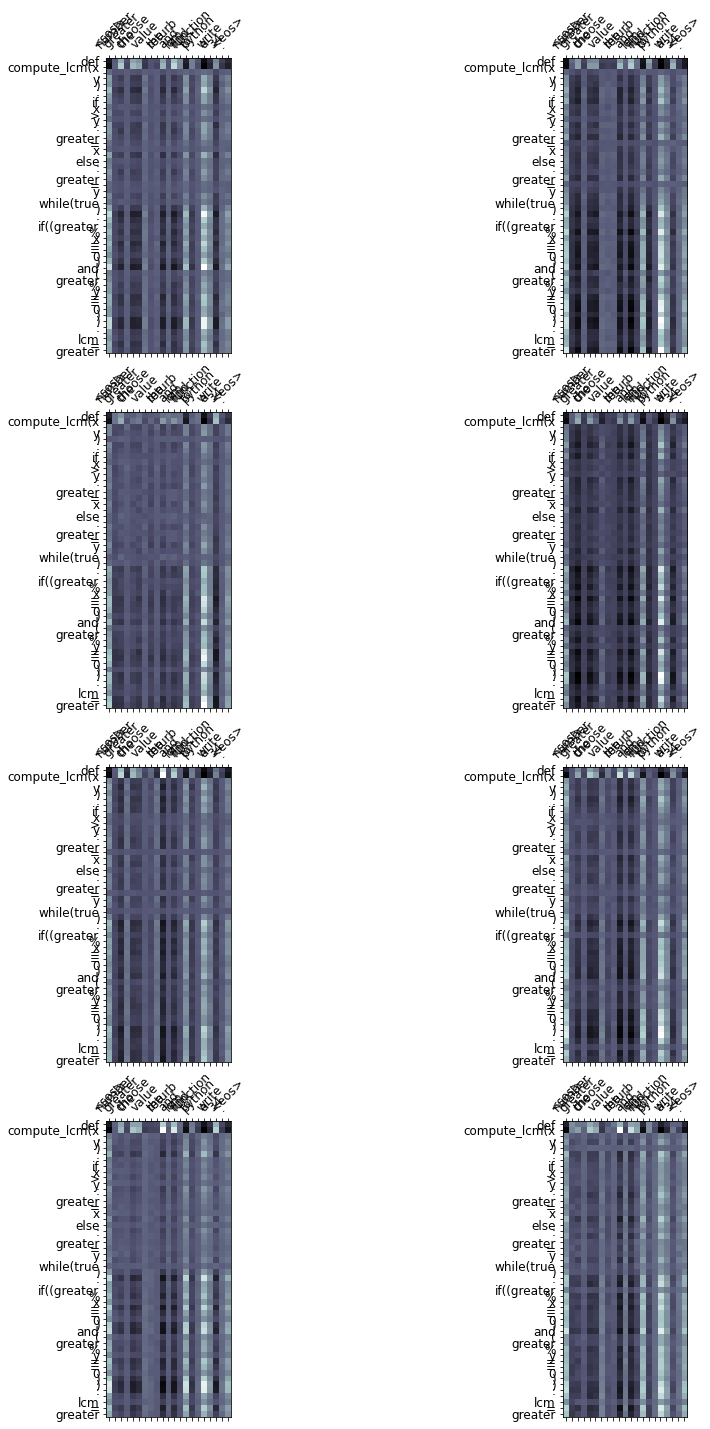

In [38]:
display_attention(src, translation, attention)